# ARIMA Models(core)

*  by *Nicholas Giuffrida*

In [32]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import set_config
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs
import itertools
set_config(transform_output="pandas")
plt.rcParams["figure.figsize"] = (13, 6)
sns.set_context("poster", font_scale=0.9)

In [2]:
# Load data
fpath = "Data/WMT.csv"
df = pd.read_csv(fpath)
df.head()

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5479 non-null   object 
 1   Adj Close  5284 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.7+ KB


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date']

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
5474   2020-12-25
5475   2020-12-28
5476   2020-12-29
5477   2020-12-30
5478   2020-12-31
Name: Date, Length: 5479, dtype: datetime64[ns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5479 non-null   datetime64[ns]
 1   Adj Close  5284 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.7 KB


In [6]:
df = df.set_index('Date')
df

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


In [7]:
df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2020-12-18', '2020-12-21', '2020-12-22', '2020-12-23',
               '2020-12-24', '2020-12-25', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=5479, freq=None)

In [8]:
# Resample for business day with 'B'
df = df.resample('B').asfreq()
df

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756
2000-01-05,42.352402
2000-01-06,42.814564
2000-01-07,46.049828
...,...
2020-12-25,NaN
2020-12-28,142.946777
2020-12-29,142.041183


In [9]:
# Check for nulls
df.isna().sum()

Adj Close    195
dtype: int64

In [10]:
null = df.isna()
df[null]

,Adj Close
Date,
2000-01-03,NaN
2000-01-04,NaN
2000-01-05,NaN
2000-01-06,NaN
2000-01-07,NaN
...,...
2020-12-25,NaN
2020-12-28,NaN
2020-12-29,NaN


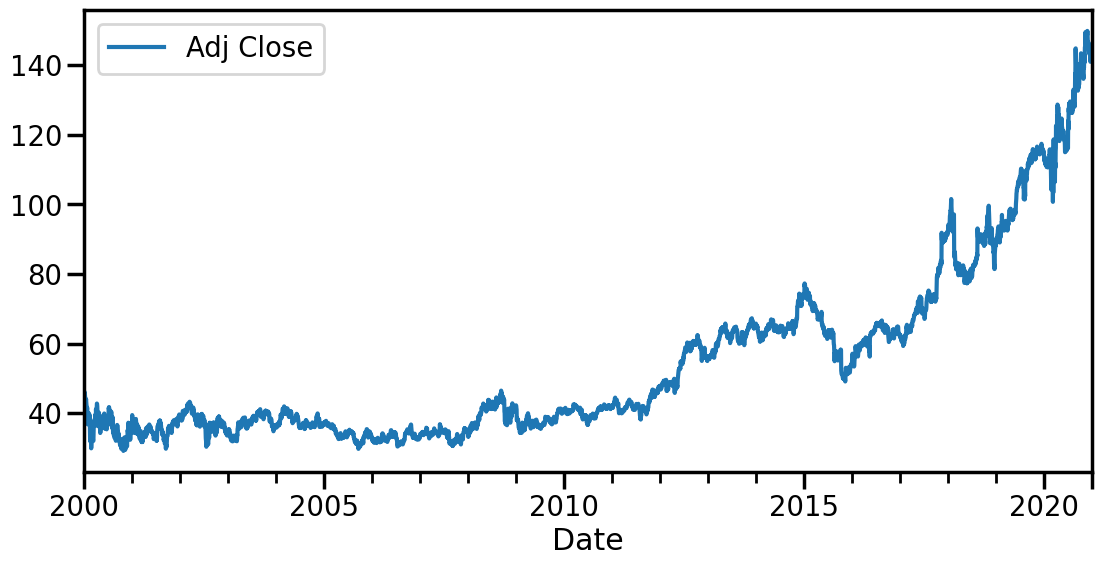

In [11]:
df = df.fillna(method='ffill')
df.plot();

In [12]:
df.isna().sum()

Adj Close    0
dtype: int64

In [13]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs):
    # Save each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [14]:
get_adfuller_results(df)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,2.45764,32,5446,0.999035,0.05,False


In [15]:
# use ndiffs to determine differencing
d = ndiffs(df)
print(f'd is {d}')

d is 2


In [16]:
df_diff2 =df.diff().diff().dropna()

In [17]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)

    # ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        # Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        # for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

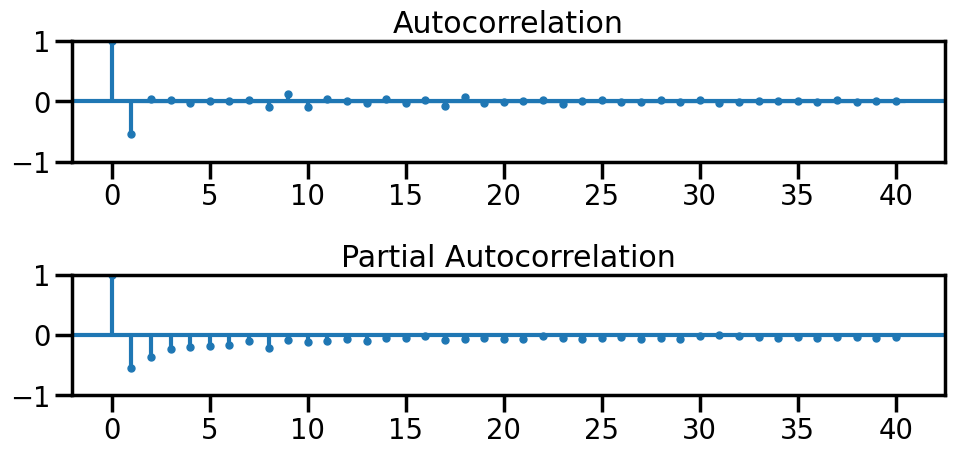

In [31]:
plot_acf_pacf(df_diff2);

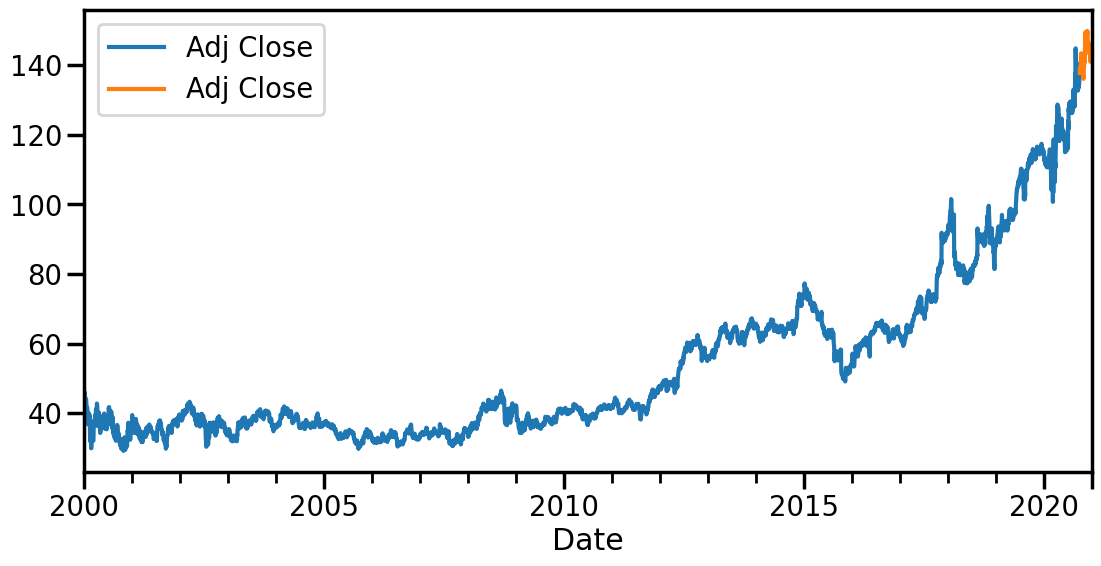

In [19]:
# Calculating number of test lags
n_test_lags = 5*13
# Modeling to predict 6 months into the future
train, test = train_test_split(df, test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [20]:
# Build the model 
p = 0  # AR component 
d = 2  # Number of differencing required to make stationary
q =  1 # MA component 
# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

In [21]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    # PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [22]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.720
- MSE = 12.223
- RMSE = 3.496
- R^2 = 0.050
- MAPE = 1.88%


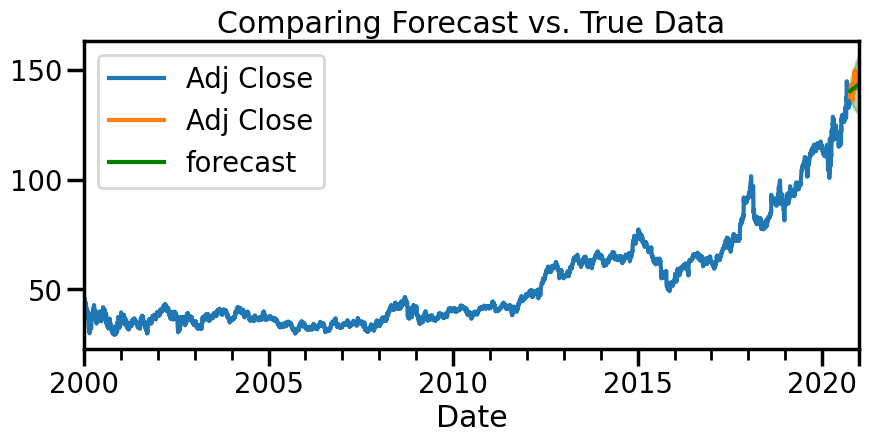

In [23]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [24]:
# Obtain summary of model
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                 5414
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -6682.931
Date:                Tue, 24 Oct 2023   AIC                          13369.863
Time:                        21:22:08   BIC                          13383.056
Sample:                    01-03-2000   HQIC                         13374.468
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.001  -1591.272      0.000      -1.000      -0.998
sigma2         0.6911      0.003    220.361      0.000       0.685       0.697
===================================================================================
Ljung-Box (L1) (Q):                  50.45   Jarque-Bera (JB):            265912.32
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.15   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

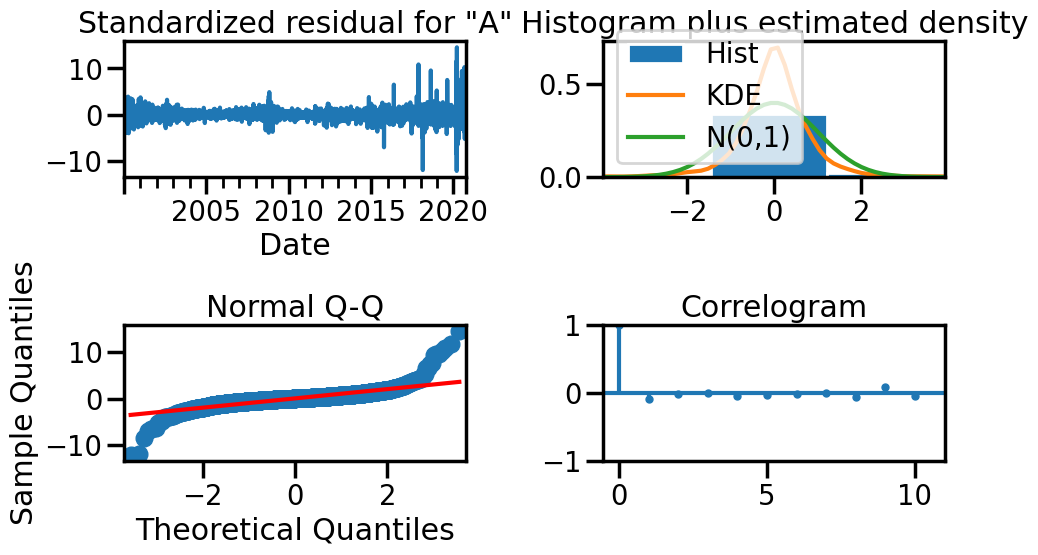

In [25]:
# Obtain diagnostic plots
fig = arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [33]:
# Define the value or range of values for p, d, q
p_values = range(0, 4)  
d_values = [2]          
q_values = range(0, 4)  

# Create combinations of pdq to test
pdq_to_try = list(itertools.product(p_values, d_values, q_values))
                                            
pdq_to_try

[(0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (1, 2, 0),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (2, 2, 0),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (3, 2, 0),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3)]

In [34]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdq = (0,0,0)

# Loop through each combination
for pdq in pdq_to_try:
    
    model = tsa.ARIMA(train, order=pdq)
                              
    result = model.fit()
    
    print(pdq, result.aic)      
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdq = pdq

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 2, 0) 17599.851772490147
(0, 2, 1) 13369.8628282289
(0, 2, 2) 13319.347183204562
(0, 2, 3) 13320.344007517779
(1, 2, 0) 15737.03032826242
(1, 2, 1) 13321.060572380919
(1, 2, 2) 13373.862431851854


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 2, 3) 13315.575864321978
(2, 2, 0) 14997.34238660675
(2, 2, 1) 13320.896147764068
(2, 2, 2) 13324.379845312014


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 2, 3) 13318.07335073825
(3, 2, 0) 14685.116539544473
(3, 2, 1) 13322.560014670435
(3, 2, 2) 13317.17626612162
(3, 2, 3) 13296.06969643076
Best AIC: 13296.06969643076
Best pdq: (3, 2, 3)


/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
p = 3  # AR component 

d = 2  # Number of differencing required to make stationary

q =  3 # MA component 

# Define and fit the model
ar_2_ma_3_model = tsa.ARIMA(train, order=(p,d,q)).fit()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


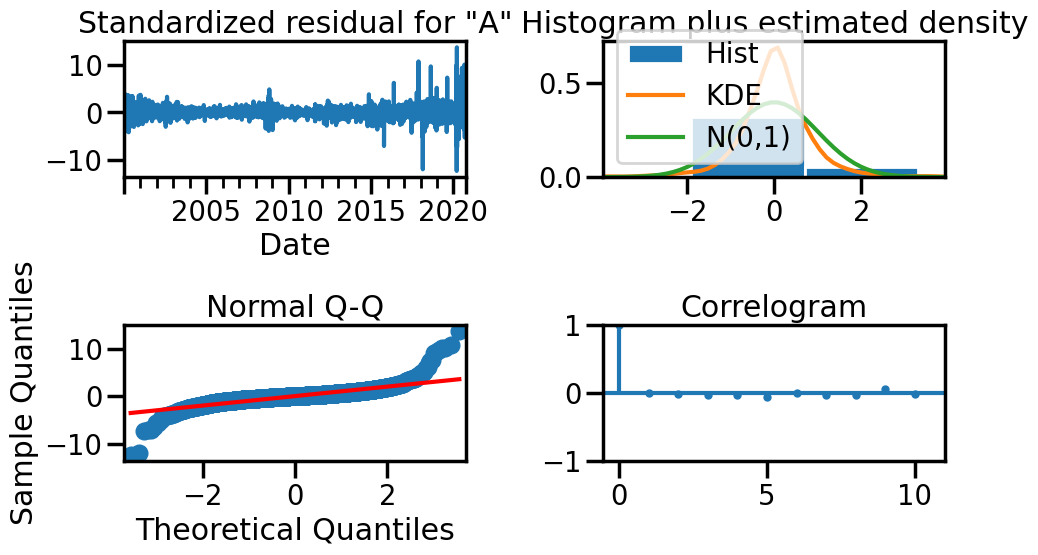

In [37]:
# Obtain diagnostic plots
fig = ar_2_ma_3_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 2.883
- MSE = 14.246
- RMSE = 3.774
- R^2 = -0.108
- MAPE = 1.98%


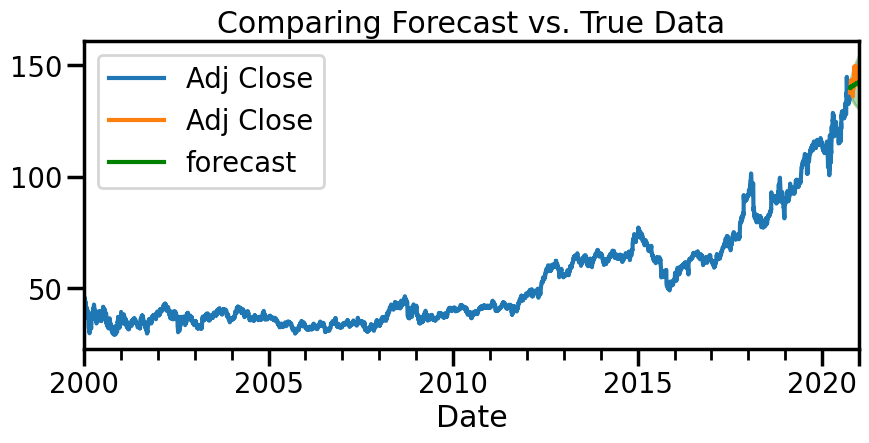

In [38]:
# Obtain summary of forecast as dataframe
forecast_df = ar_2_ma_3_model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])